In [74]:
import numpy as np
import pandas as pd
import scipy
import scipy.stats
import math
import random
import matplotlib.pyplot as plt
import pickle

### Data Generation

In [75]:
class Model:
    def __init__(self, time_length):
        self.T = time_length
        self.num_treatments = 1
        self.X = np.zeros((self.T, self.num_treatments))
        self.A = np.array([[-.5], [-.2]]) # the coefficients a_j's stored in a matrix
        self.b = .4
        self.c = 1
        self.noise_0 = .01
        self.noise_1 = .01
        self.noise_2 = .5
        self.init_z = 6
        self.z = np.zeros(time_length)
        self.y = np.zeros(time_length)
        self.pi = np.zeros(time_length)
        
    def set_X(self):
        for t in range(self.T):
            self.X[t, :] = np.random.randint(2, size = self.num_treatments)
    
    def transition(self, prev):
        z = np.random.normal(prev, model.noise_1, 1)
        return z

    def emission(self, z, t):
        treatment_effect = 0
        for j in range(np.shape(self.A)[0]):
            if t-1 >= j:
                treatment_effect += np.dot(self.A[j, :], self.X[t-1-j, :])
        pi = treatment_effect + np.dot(self.b, self.c) # total added effect
        mean = z + pi
        y = np.random.normal(mean, self.noise_2, 1)
        return y, pi
    
    def run_simulation(self):
        self.set_X()
        self.z[0] = self.init_z
        self.y[0], self.pi[0] = self.emission(self.z[0], 0)
        for t in range(1, self.T):
            self.z[t] = self.transition(self.z[t-1])
            self.y[t], self.pi[t] = self.emission(self.z[t], t)
    
    def plot_trajectory(self):
        times = list(range(self.T))
        plt.plot(times, self.y, label = 'observed')
        plt.plot(times, self.z, label = 'counterfactual')
        for t in np.nonzero(self.X)[0]:
            plt.axvline(x=t, color='g', linestyle='--')
        plt.xlabel('time (hr)')
        plt.ylabel('INR')
        plt.title('Simulated trajectory')
        plt.legend()
        plt.show()

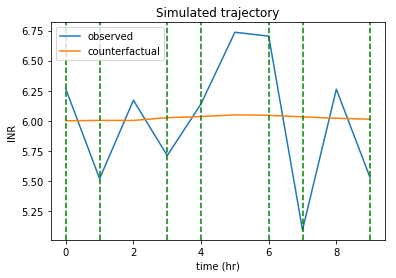

In [76]:
model = Model(10)
model.run_simulation()
model.plot_trajectory()

### E step

In [106]:
class EM:
    def __init__(self, y, X, c, N, M, K, J):
        # Store observed sequence, treatments, chronic conditions
        self.y = y
        self.X = X # treatment matrix
        self.c = c # chronic conditions
        
        # Fixed model parameters
        self.T = np.shape(y)[0] # length of the observed sequence
        self.N = N # number of treatments
        self.M = M # number of chronic conditions
        self.K = K # number of interaction terms modeled
        self.J = J # number of past treatment effects to be considered
        
        # Model Parameters to be estimated
        self.A = np.zeros((N, J)) # coefficients a_j's
        self.b = np.zeros(M)
        self.d = np.zeros(K)
        self.sigma_1 = 0
        self.sigma_2 = 0
        self.sigma_0 = 0 # initial state variance
        self.init_z = 0 # initial state mean
        
        # Intermediate values to stored
        self.mu_filter = np.zeros(self.T) # mu_t|t
        self.sigma_filter = np.zeros(self.T) # sigma^2_t|t
        self.kgain = np.zeros(self.T) # K_t, kalman gain
        self.jgain = np.zeros(self.T) # J_t, backward kalman gain 
        self.mu_smooth = np.zeros(self.T) # mu_t|T
        self.sigma_smooth = np.zeros(self.T) # sigma^2_t|T
        self.mu_square_smooth = np.zeros(self.T) # E[z_t^2|{y}]
        self.mu_ahead_smooth = np.zeros(self.T) # E[z_t * z_{t-1}|{y}]
        self.sigma_ahead_smooth = np.zeros(self.T)
        self.Q_const = 0 # store computations for Q function 
    
    def set_params(self):                
        self.A = model.A
        self.b = model.b
        self.sigma_0 = model.noise_0
        self.sigma_1 = model.noise_1
        self.sigma_2 = model.noise_2
        self.init_z = model.init_z
    
    # compute the added effect, denoted pi_t, at time t given the current parameter values 
    def added_effect(self, t):
        treatment_effect = 0
        for j in range(np.shape(self.A)[0]):
            if t-1 >= j:
                treatment_effect = treatment_effect + np.dot(self.A[j, :], self.X[t-1-j, :])
        pi = treatment_effect + np.dot(self.b, self.c) # total added effect
        return pi
    
    # reduce the terms Q_function needs to unpack by computing some terms first
    # note that after E step, all except for the last term of Q function are constant
    def compute_Q_const(self):
        # compute terms involving logs
        log_term = -self.T * np.log(2*np.pi) - np.log(self.sigma_0)/2 - (self.T-1)/2 * np.log(self.sigma_1) \
         - self.T * self.sigma_2 / 2
        # compute the first term with expected value
        first_E = -1/(2*self.sigma_0)*(self.mu_smooth[0]-2*self.init_z*self.mu_smooth[0]+self.init_z^2)
        # compute the second term with expected value
        sqaure_term = np.roll(self.mu_square_smooth, -1)-2*self.mu_ahead_smooth+self.mu_square_smooth
        # delete the last value since mu_ahead_smooth has one less term
        square_term = np.delete(square_term, np.shape(square_term)[0]-1)
        second_E = -1/(2*self.sigma_1)*np.sum(square_term)
        self.Q_const = log_term + first_E + second_E
        
    def Q_function(self):
        
    
    # kalman filter update step
    def kfilter(self, t):
        self.kgain[t+1] = (self.sigma_0 + t * self.sigma_1) / (self.sigma_0 + t * self.sigma_1 + self.sigma_2)
        mu_pred = self.mu_filter[t] 
        self.mu_filter[t+1] = mu_pred + self.kgain[t+1] * (self.y[t+1] - mu_pred - self.added_effect(t+1))
        sigma_pred = self.sigma_filter[t] + self.sigma_1
        self.sigma_filter[t+1] = (1 - self.kgain[t+1]) * sigma_pred
    
    # kalman filter for each time point, message passing forward
    def forward(self):
        self.mu_filter[0] = self.init_z
        self.sigma_filter[0] = self.sigma_0
        for t in range(self.T-1):
            self.kfilter(t)
    
    # kalman smoother update step
    def ksmoother(self, t):
        sigma_pred = self.sigma_filter[t] + self.sigma_1 # sigma^2_t+1|t
        self.jgain[t] = self.sigma_filter[t] / sigma_pred
        self.mu_smooth[t] = self.mu_filter[t] + self.jgain[t] * (self.mu_smooth[t+1] - self.mu_filter[t])
        self.sigma_smooth[t] = self.sigma_filter[t] + np.square(self.jgain[t]) * (self.sigma_smooth[t+1] - sigma_pred)
        self.mu_square_smooth[t] = self.sigma_smooth[t] + np.square(self.mu_smooth[t])
    
    def backward(self):
        self.mu_smooth[self.T-1] = self.mu_filter[self.T-1]
        self.mu_square_smooth[self.T-1] = self.sigma_smooth[self.T-1] + np.square(self.mu_smooth[self.T-1])
        for t in range(self.T-2, -1, -1):
            self.ksmoother(t)     
    
    # backward recursion to compute sigma^2_{t, t-1}|T, which is necessary to compute mu_ahead_smooth
    def backward_sigma_ahead(self, t):
        if t == self.T-2:
            self.sigma_ahead_smooth[t] = (1 - self.kgain[t]) * self.sigma_smooth[t]
            return self.sigma_ahead_smooth[t]
        else:
            sigma_ahead = self.backward_sigma_ahead(t+1)
            self.sigma_ahead_smooth[t] = self.sigma_smooth[t] * self.jgain[t-1] + \
                self.jgain[t] * (sigma_ahead - self.sigma_smooth[t]) * self.jgain[t-1]
            return self.sigma_ahead_smooth[t]
    
    def calc_mu_ahead_smooth(self):
        for t in range(self.T-1):
            self.mu_ahead_smooth[t] = self.sigma_ahead_smooth[t] + self.mu_smooth[t] * self.mu_smooth[t+1]
    
    def E_step(self):
        self.set_params()
        self.forward()
        self.backward()
        self.backward_sigma_ahead(0)
        self.calc_mu_ahead_smooth()
        
    def plot(self):
        times = list(range(len(self.y)))
        plt.plot(times, self.y, label = 'observed values')
        plt.plot(times, model.z, label = 'true values')
        plt.plot(times, self.mu_filter, label = 'filtered values')
        plt.plot(times, self.mu_smooth, label = 'smoothened values')
        plt.xlabel('time (hr)')
        plt.ylabel('INR')
        plt.title('Kalman Filter Results')
        plt.legend()
        plt.show()

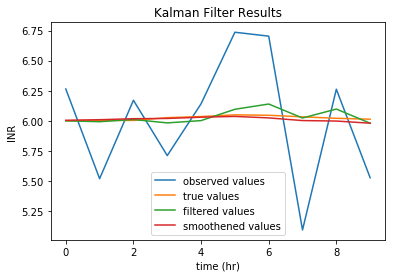

In [107]:
em = EM(model.y, model.X, model.c, 1, 1, 0, 2)
em.E_step()
em.plot()

In [111]:
a = em.mu_square_smooth

In [112]:
b = em.mu_smooth

In [113]:
c = em.mu_ahead_smooth

In [117]:
d = np.roll(a, -1)

In [118]:
a

array([36.06297406, 36.12348196, 36.22879742, 36.25863216, 36.38250654,
       36.4609287 , 36.30975914, 36.03821873, 35.98503459, 35.76112308])

In [119]:
d

array([36.12348196, 36.22879742, 36.25863216, 36.38250654, 36.4609287 ,
       36.30975914, 36.03821873, 35.98503459, 35.76112308, 36.06297406])

In [124]:
x = a + d - 2*c

In [125]:
x

array([ 2.37529477e-02,  2.42294068e-02,  2.57779993e-02,  2.69217963e-02,
        2.64226675e-02,  2.39326351e-02,  1.87723066e-02,  8.85172916e-03,
       -5.81031715e-03,  7.18240971e+01])

In [123]:
np.delete(x, x.shape[0]-1)

array([ 0.02375295,  0.02422941,  0.025778  ,  0.0269218 ,  0.02642267,
        0.02393264,  0.01877231,  0.00885173, -0.00581032])